In [1]:
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from yellowbrick.regressor import ResidualsPlot
from yellowbrick.regressor import PredictionError
from yellowbrick.regressor import prediction_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, mutual_info_regression

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
base_path = '/kaggle/input/self-reported-qol/20230625-processed-'

df_physical      = pd.read_csv(base_path + 'physical-qol.csv')
df_psychological = pd.read_csv(base_path + 'psychological-qol.csv')

df_physical.drop('id', axis=1, inplace=True)         # id
df_physical.drop('day', axis=1, inplace=True)        # day
df_psychological.drop('id', axis=1, inplace=True)    # id
df_psychological.drop('day', axis=1, inplace=True)   # day

phy_all_tmp = df_physical.copy()
phy_init_set_tmp = phy_all_tmp.query("group in ('Initial Set')").copy()
phy_ufpi_ufc_tmp = phy_all_tmp.query("group in ('UFPI', 'UFC')").copy()

psy_all_tmp = df_psychological.copy()
psy_init_set_tmp = psy_all_tmp.query("group in ('Initial Set')").copy()
psy_ufpi_ufc_tmp = psy_all_tmp.query("group in ('UFPI', 'UFC')").copy()

phy_all_tmp.drop("group", axis=1, inplace=True)
phy_init_set_tmp.drop("group", axis=1, inplace=True)
phy_ufpi_ufc_tmp.drop("group", axis=1, inplace=True)

psy_all_tmp.drop("group", axis=1, inplace=True)
psy_init_set_tmp.drop("group", axis=1, inplace=True)
psy_ufpi_ufc_tmp.drop("group", axis=1, inplace=True)

# Separating predictors from the values to be predicted.
phy_all           = phy_all_tmp.drop("phy_ref_score", axis=1)
phy_all_pred      = phy_all_tmp["phy_ref_score"].copy()
phy_init_set      = phy_init_set_tmp.drop("phy_ref_score", axis=1)
phy_init_set_pred = phy_init_set_tmp["phy_ref_score"].copy()
phy_ufpi_ufc      = phy_ufpi_ufc_tmp.drop("phy_ref_score", axis=1)
phy_ufpi_ufc_pred = phy_ufpi_ufc_tmp["phy_ref_score"].copy()

psy_all           = psy_all_tmp.drop("psy_ref_score", axis=1)
psy_all_pred      = psy_all_tmp["psy_ref_score"].copy()
psy_init_set      = psy_init_set_tmp.drop("psy_ref_score", axis=1)
psy_init_set_pred = psy_init_set_tmp["psy_ref_score"].copy()
psy_ufpi_ufc      = psy_ufpi_ufc_tmp.drop("psy_ref_score", axis=1)
psy_ufpi_ufc_pred = psy_ufpi_ufc_tmp["psy_ref_score"].copy()

In [3]:
def getDataset(domain_group):
    return {
        'phy_all': (phy_all, phy_all_pred),
        'psy_all': (psy_all, psy_all_pred),
        
        'phy_init_set': (phy_init_set, phy_init_set_pred),
        'psy_init_set': (psy_init_set, psy_init_set_pred),
        
        'phy_ufpi_ufc': (phy_ufpi_ufc, phy_ufpi_ufc_pred),
        'psy_ufpi_ufc': (psy_ufpi_ufc, psy_ufpi_ufc_pred),
    }[domain_group]

In [4]:
# https://www.scikit-yb.org/en/latest/api/regressor/residuals.html
# https://towardsdatascience.com/what-are-the-best-metrics-to-evaluate-your-regression-model-418ca481755b
def buildResidualGraph(domain_group, regressor, mytitle, filename):
    X, y = getDataset(domain_group)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=42)

    figure(figsize=(8, 4), dpi=300)
    visualizer = ResidualsPlot(regressor, title=" ")

    visualizer.fit(X_train, y_train)
    visualizer.score(X_test, y_test)
    visualizer.show(outpath=filename)

In [5]:
# https://www.scikit-yb.org/en/latest/api/regressor/peplot.html
def buildPredictionErrorGraph(domain_group, regressor, mytitle, filename):
    X, y = getDataset(domain_group)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=42)

    figure(figsize=(8, 4), dpi=300)
    visualizer = PredictionError(regressor, title=" ")
    visualizer.fit(X_train, y_train)
    visualizer.score(X_test, y_test)
    visualizer.show(outpath=filename)

In [6]:
def get_rforest_phy():
    skb = SelectKBest(score_func=mutual_info_regression, k = 70)
    alg = RandomForestRegressor(warm_start=False, n_estimators=894, min_samples_split=5, min_samples_leaf=2, max_features=1.0, max_depth=10, criterion='squared_error', bootstrap=True, random_state=42)
    return Pipeline([('feat_selection', skb), ('regressor', alg)])

In [7]:
def get_rforest_psy():
    skb = SelectKBest(score_func=mutual_info_regression, k = 50)
    alg = RandomForestRegressor(warm_start=False, n_estimators=1778, min_samples_split=2, min_samples_leaf=1, max_features='sqrt', max_depth=None, criterion='poisson', bootstrap=False, random_state=42)
    return Pipeline([('feat_selection', skb), ('regressor', alg)])

In [8]:
def rmsle_cv(model, domain_group):
    start = time.time()
    
    X, y = getDataset(domain_group)
    kf = KFold(10, shuffle = True, random_state = 42).get_n_splits(X.values)
    rmse = np.sqrt(-cross_val_score(model, X.values, y, scoring = "neg_mean_squared_error", cv = kf))
    mae  = -cross_val_score(model, X.values, y, scoring = "neg_mean_absolute_error", cv = kf)
    r2 = cross_val_score(model, X.values, y, scoring = "r2", cv = kf)
    
    end = time.time()
    exec_time = end - start

    print('Time:', exec_time, 'MAE:', round(mae.mean(), 4), 'RMSE:',  round(rmse.mean(), 4), 'R^2:', round(r2.mean(), 4), '\n')

In [9]:
rmsle_cv(get_rforest_phy(), 'phy_all')
rmsle_cv(get_rforest_phy(), 'phy_init_set')
rmsle_cv(get_rforest_phy(), 'phy_ufpi_ufc')

Time: 646.9599621295929 MAE: 5.6749 RMSE: 7.9651 R^2: 0.7294 

Time: 511.13678193092346 MAE: 4.8113 RMSE: 6.9201 R^2: 0.7733 

Time: 133.90095829963684 MAE: 7.385 RMSE: 9.9906 R^2: 0.5868 



In [10]:
rmsle_cv(get_rforest_psy(), 'psy_all')
rmsle_cv(get_rforest_psy(), 'psy_init_set')
rmsle_cv(get_rforest_psy(), 'psy_ufpi_ufc')

Time: 494.87341237068176 MAE: 5.3833 RMSE: 7.4438 R^2: 0.7649 

Time: 380.45402574539185 MAE: 4.0785 RMSE: 5.8231 R^2: 0.8285 

Time: 117.9883484840393 MAE: 8.0678 RMSE: 10.3509 R^2: 0.5544 



In [11]:
sns.set_style("whitegrid", {'axes.grid' : False})

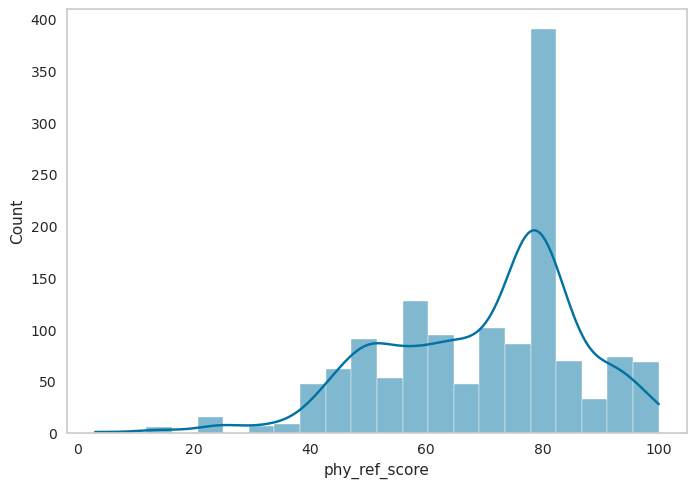

In [12]:
sns.histplot(data=df_physical, x="phy_ref_score", kde=True)
plt.show()

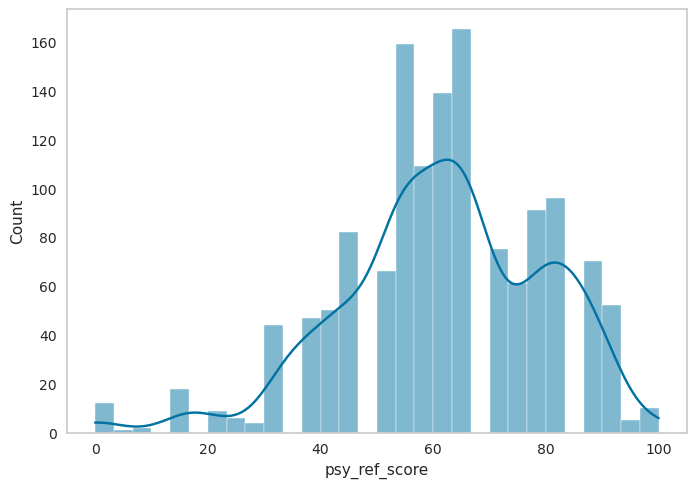

In [13]:
sns.histplot(data=df_psychological, x="psy_ref_score", kde=True, bins=30)
plt.show()

Time: 644.5295608043671 MAE: 5.6565 RMSE: 7.9586 R^2: 0.7264 



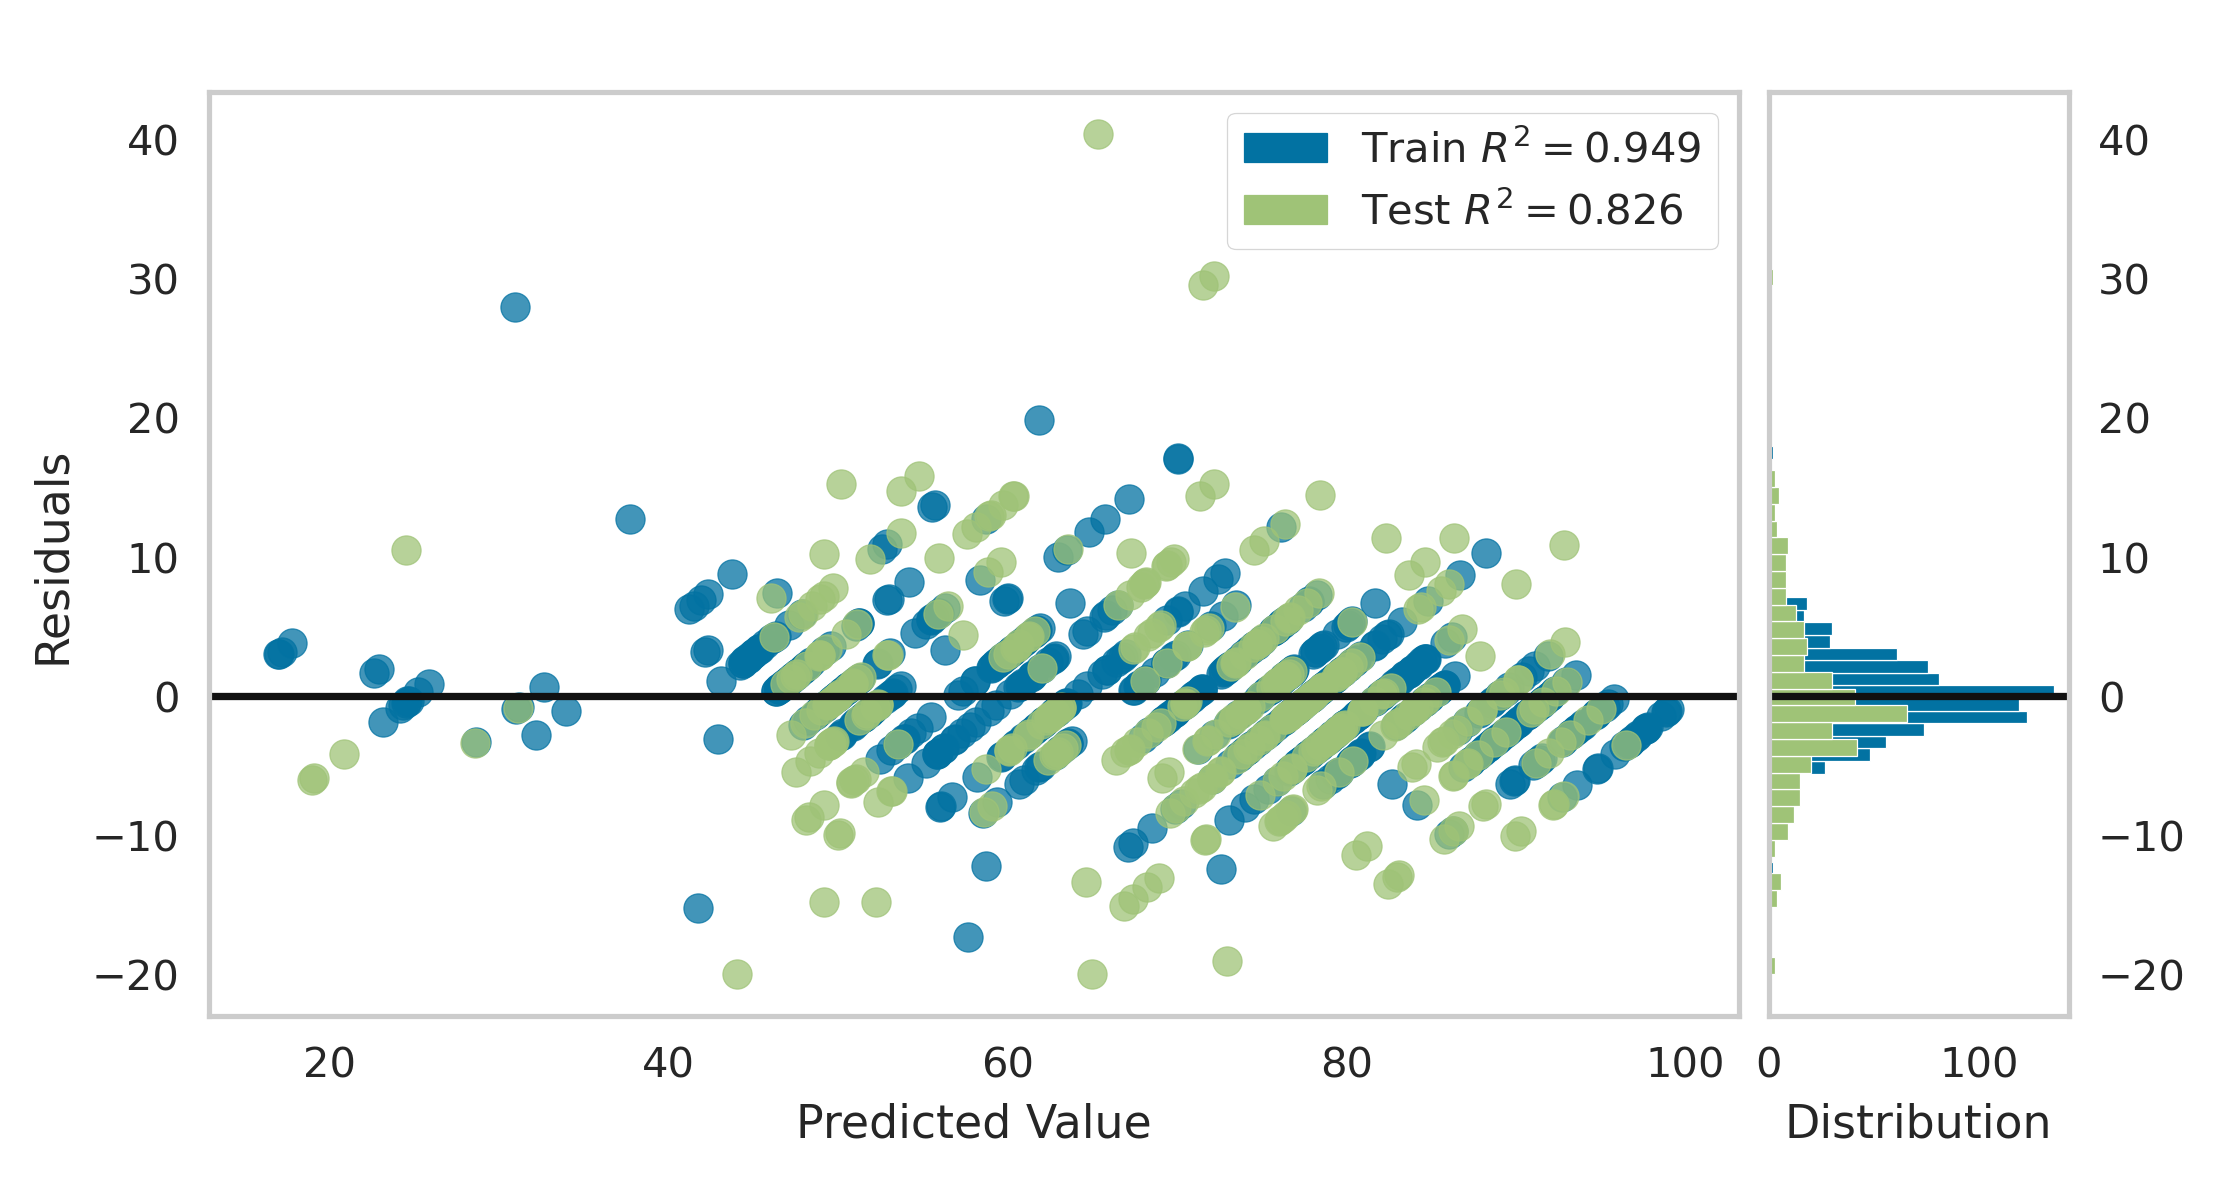

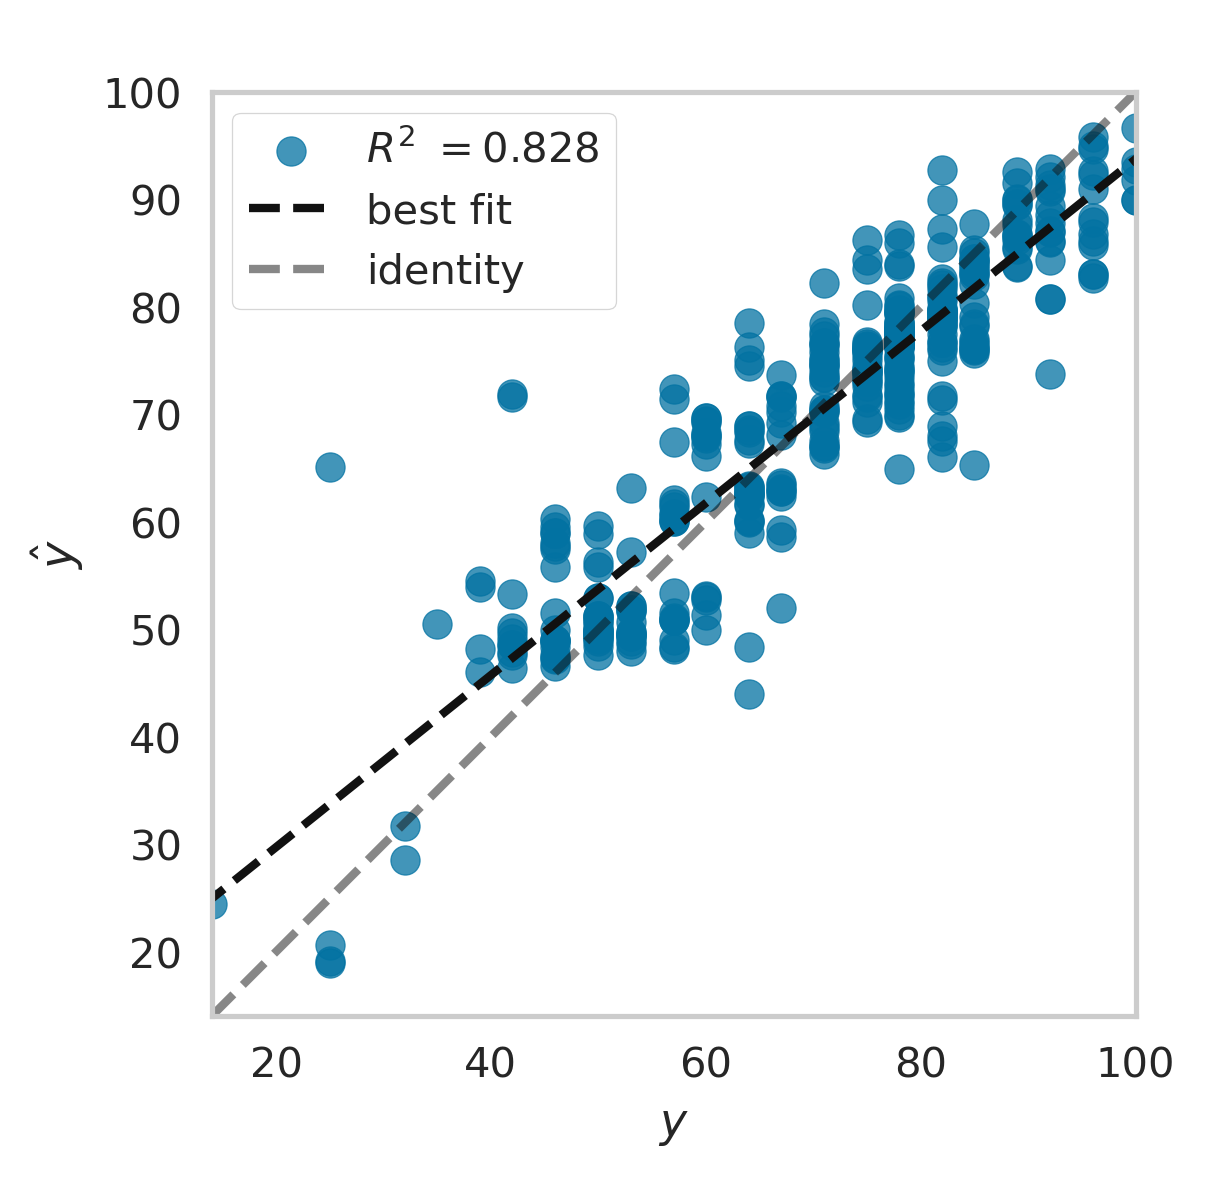

In [14]:
domain = 'phy_all'
rmsle_cv(get_rforest_phy(), domain)
buildResidualGraph(domain, get_rforest_phy(), 'Residuals for Random Forest Regressor considering Physical Dataset', 'residuals-phy-rforest.pdf')
buildPredictionErrorGraph(domain, get_rforest_phy(), 'Prediction Error for Random Forest Regressor considering Physical Dataset', 'errors-phy-rforest.pdf')

Time: 497.0195128917694 MAE: 5.3769 RMSE: 7.4308 R^2: 0.7649 



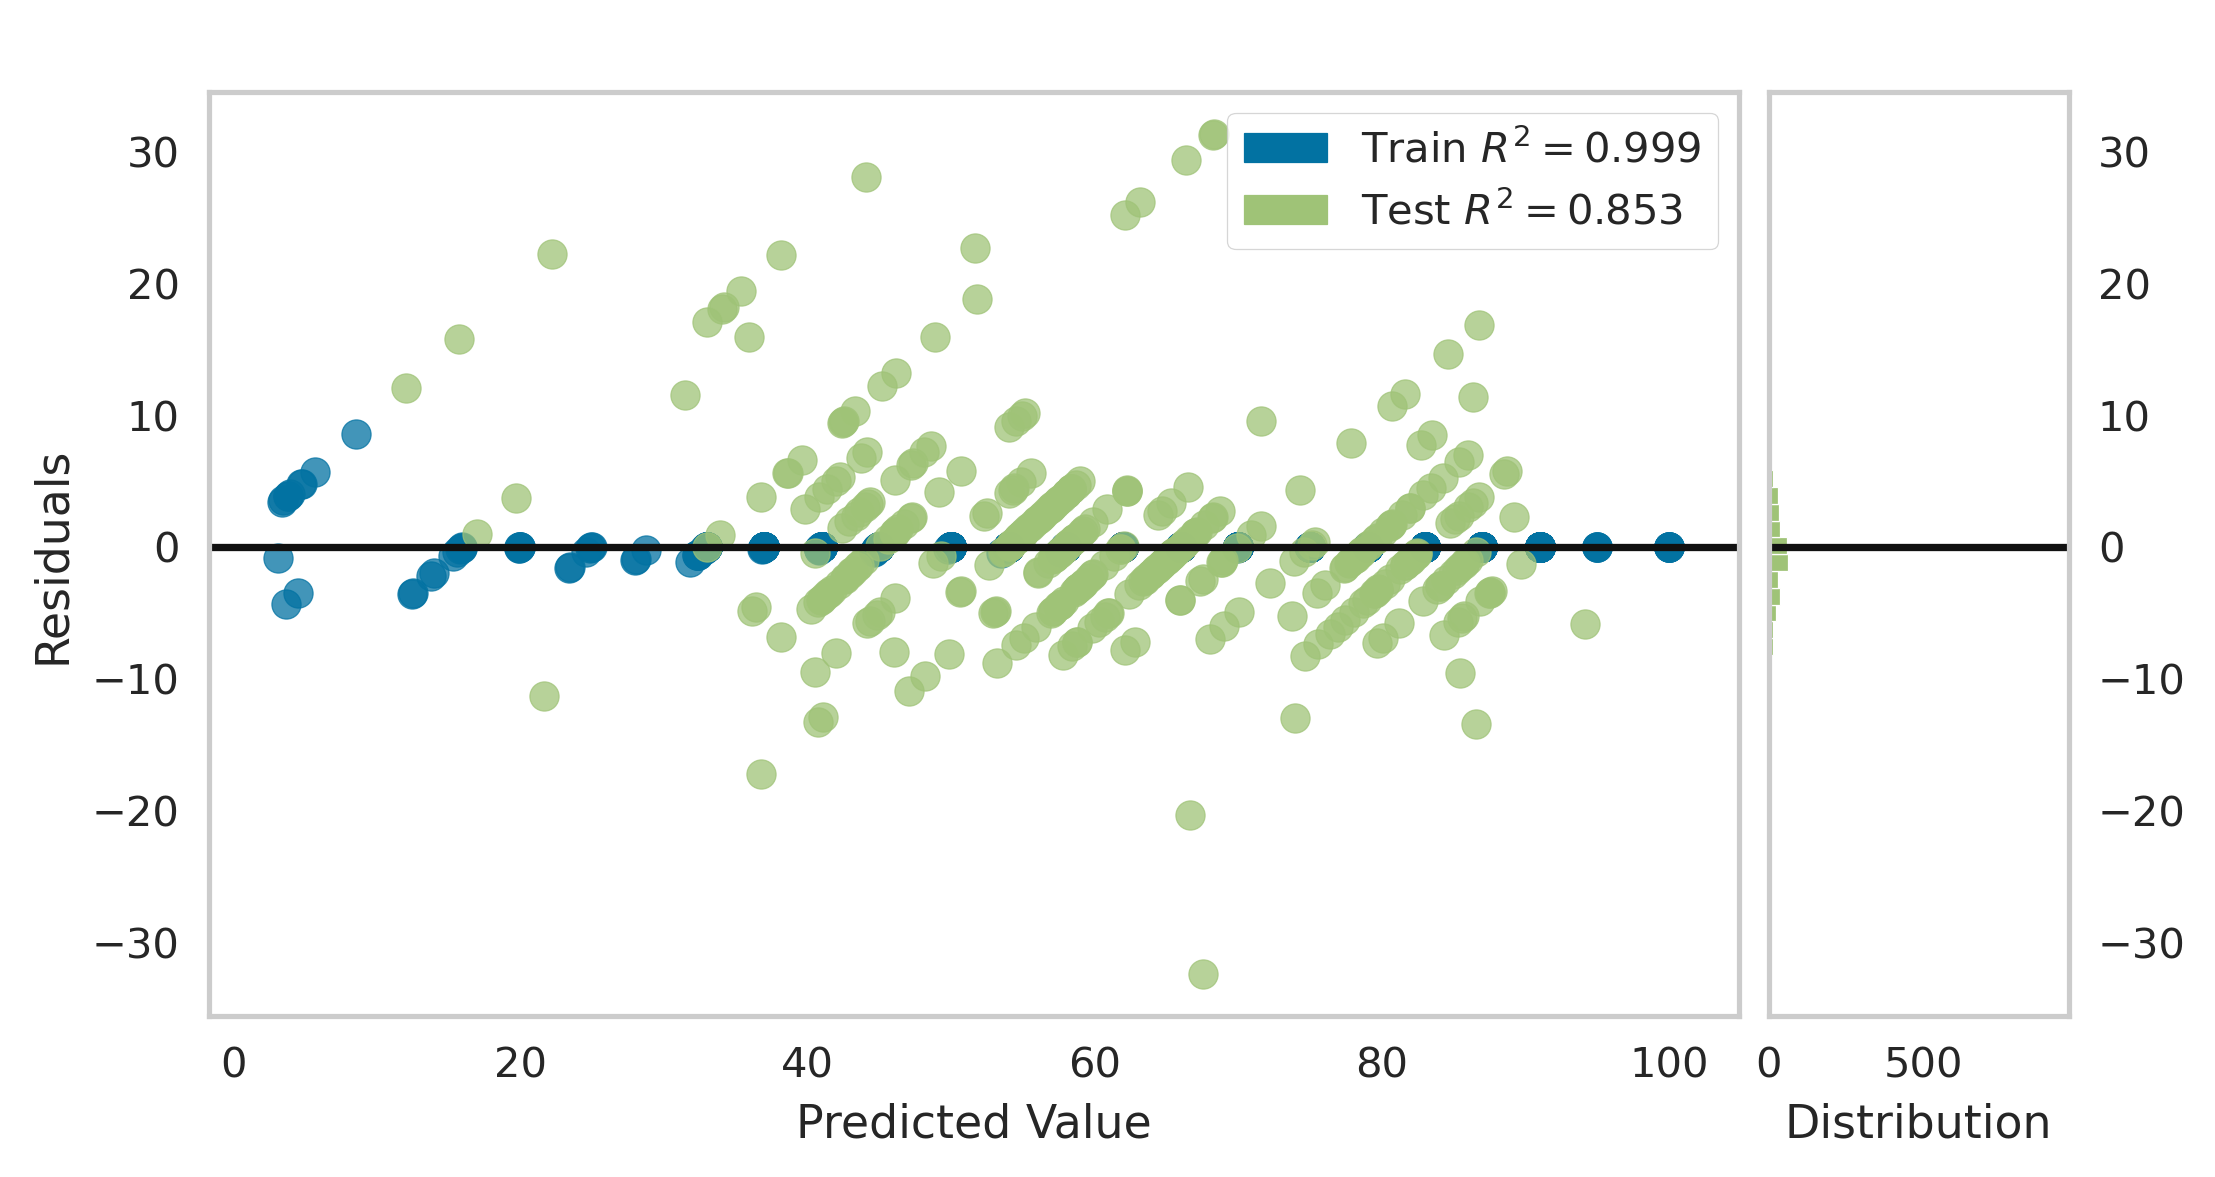

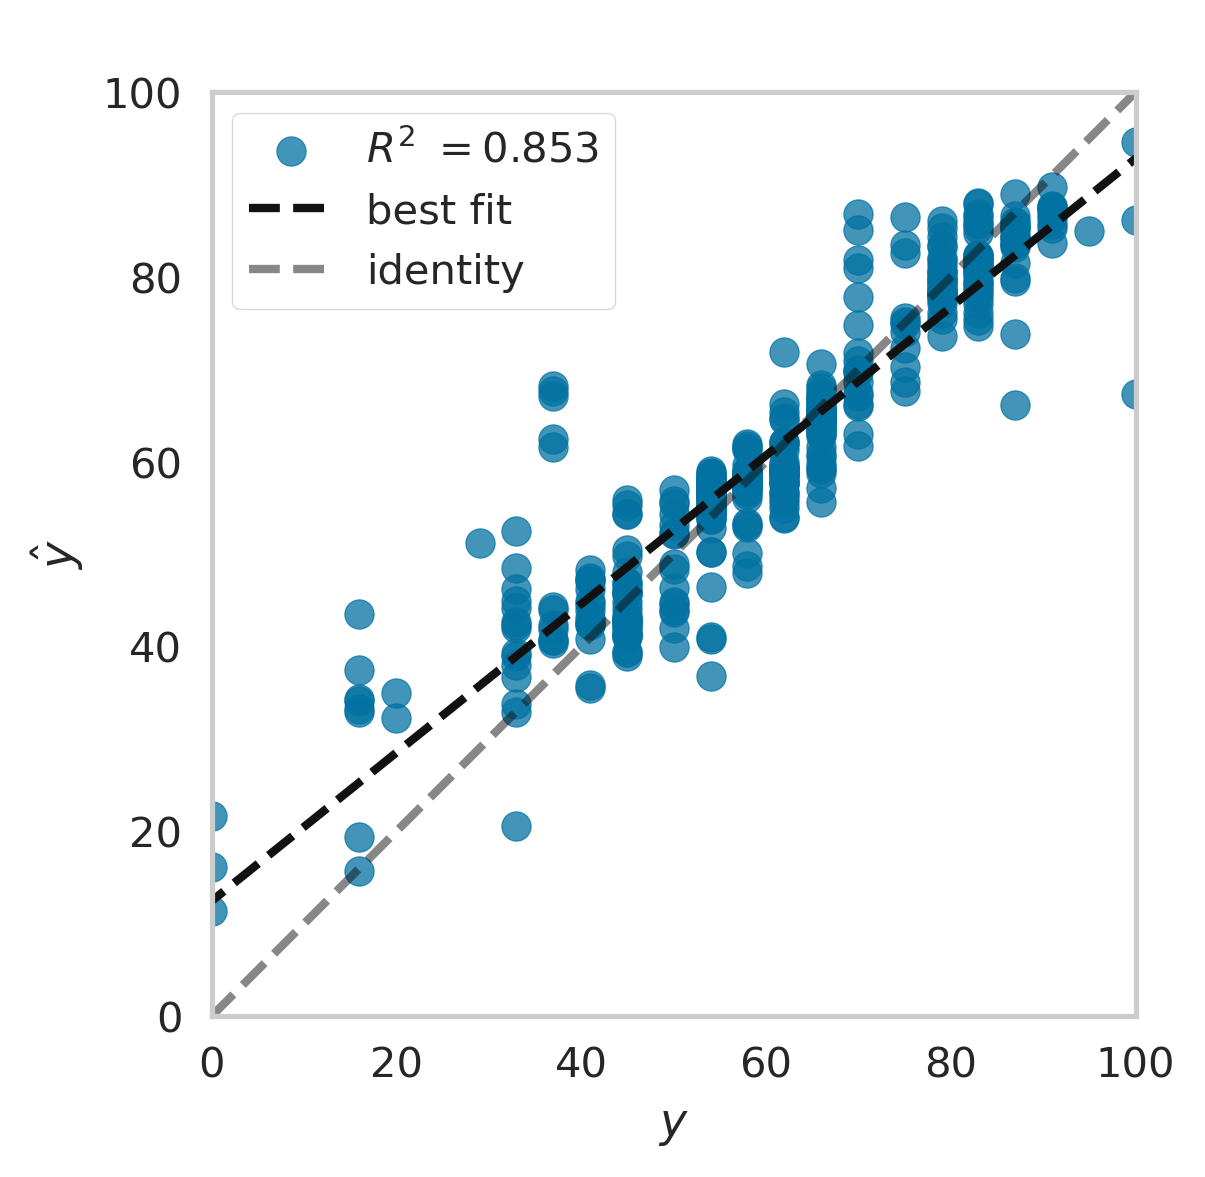

In [15]:
domain = 'psy_all'
rmsle_cv(get_rforest_psy(), domain)
buildResidualGraph(domain, get_rforest_psy(), 'Residuals for Random Forest Regressor considering Psychological Dataset', 'residuals-psy-rforest.pdf')
buildPredictionErrorGraph(domain, get_rforest_psy(), 'Prediction Error for Random Forest Regressor considering Psychological Dataset', 'errors-psy-rforest.pdf')